Based on June 2018 version of [Sarcasm in News Headlines Dataset by Rishabh Misra](https://rishabhmisra.github.io/publications/) 

In [ ]:
# get shorten data 
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O ../tmp/sarcasm.json

In [1]:
# load data
import json

with open("../tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = [] 
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [2]:
# 29K words in 27K sentences (too small for NN with 50K params learning)
vocab_size = 3000

# encode
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>", num_words=vocab_size)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print('number of words in index', vocab_size)
print('word_index')
print(list(word_index.keys())[:10])
print(list(word_index.values())[:10])


number of words in index 29657
word_index
['<OOV>', 'to', 'of', 'the', 'in', 'for', 'a', 'on', 'and', 'with']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [3]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post')
print(padded[:2])
print(padded.shape, '(# sentences, max len of sentence)') 
max_length = padded.shape[1]
print('labels')
print(labels[:10], len(labels))

[[ 308    1  679    1 2298   48  382 2576    1    6 2577    1    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   4    1    1 2746   22    2  166    1  416    1    6  258    9 1002
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
(26709, 40) (# sentences, max len of sentence)
labels
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0] 26709


## Naive FNN
Train naive FNN to predict sarcasm

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras_util as u # plot_history

x_train = padded / 29657
y_train = np.array(labels)

In [5]:
model = Sequential([
    Dense(40, activation=tf.nn.relu, input_shape=(40,)),
    Dropout(0.3),
    Dense(250, activation=tf.nn.relu),
    Dropout(0.2),
    Dense(150, activation=tf.nn.relu),
    Dropout(0.1),
    Dense(1, activation=tf.nn.sigmoid),
    ])
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1640      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               10250     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               37650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [6]:
history = model.fit(
    x_train, y_train
    , shuffle=True, validation_split=0.1
    , epochs=100, verbose=0
    , batch_size=700
#     ,callbacks=[tf.keras.callbacks.callbacks.EarlyStopping()]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


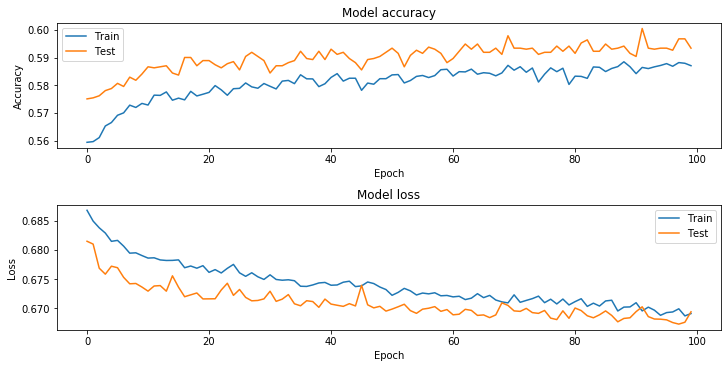

In [7]:
u.plot_history(history)

Naive FNN is about 60% accurate.

## Embending encoder with FNN
Use Embending encoder with FNN

In [8]:
x_train = padded           # (26709, 40)
y_train = np.array(labels) # (26709,)

print(x_train.shape)
print(y_train.shape)

(26709, 40)
(26709,)


In [9]:
embedding_dim = 2 # about same 50K params

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, mask_zero=True),
    tf.keras.layers.Flatten(),
    Dropout(0.2),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 2)             59316     
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 243       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 59,563
Trainable params: 59,563
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(
    x_train, y_train
    , shuffle=True, validation_split=0.1
    , epochs=40, verbose=0
    , batch_size=700
)

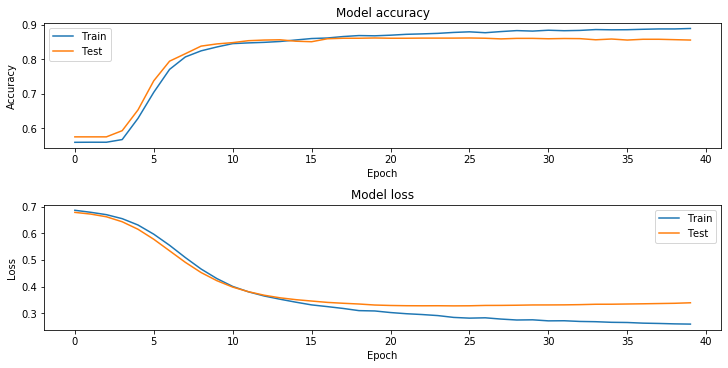

In [11]:
u.plot_history(history)

NN with embedded encoding easily (@20 epoche) gets to 85%.